<a href="https://colab.research.google.com/github/hissain/mlworks/blob/main/codes/GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [ ]:
!pip install transformers

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/BRTC/Deep Learning/Notebooks/Finetune GPT-2"

/content/drive/My Drive/BRTC/Deep Learning/Notebooks/Finetune GPT-2


In [ ]:
!ls

GPT_2_Fine_Tuning.ipynb  model_save  ra_top_1000_data_set.json


In [ ]:
# mount my Google Drive directory and access the training data located there
filename = 'ra_top_1000_data_set.json'
# load into a data frame
df = pd.read_json(filename)
print(df.head())

                             aliases         country  followers  \
0             [Inertia, Ricky Rouge]  United Kingdom       8080   
1  [Lundin Oil, Ulwhednar (w/ Varg)]          Sweden       5838   
2                                 []          France       4945   
3              [Acid Pauli, Console]         Germany      10648   
4                           [Po-Ski]  United Kingdom       7050   

                  name                id  \
0  A Guy Called Gerald  aguycalledgerald   
1       Abdulla Rashim     abdullarashim   
2            Acid Arab          acidarab   
3           Acid Pauli         acidpauli   
4              Actress           actress   

                                                 bio  \
0  When it funks, it funks hard.\n\nBreaking Beat...   
1  "Purposively ricocheting between the techno wo...   
2  Acid Arab is a duet from Paris whose goal is t...   
3  Over the last 20 years Martin Gretschmann has ...   
4                                                   

In [ ]:
df.dropna(inplace=True) #remove NA values
bios = df.bio.copy() #just use the main bio text in this example
bios

0       When it funks, it funks hard.\n\nBreaking Beat...
1       "Purposively ricocheting between the techno wo...
2       Acid Arab is a duet from Paris whose goal is t...
3       Over the last 20 years Martin Gretschmann has ...
4                                                        
                              ...                        
1009    Life is hard but music is good!As a music enth...
1010    When one could assume, &ME entered the House a...
1011    From politically incorrect prog-rock to funky ...
1012    Techno from outer space999999999 -officially s...
1013    Singer, songwriter, rapper, house and techno D...
Name: bio, Length: 1014, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<ipython-input-15-fa091b8c73b4>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

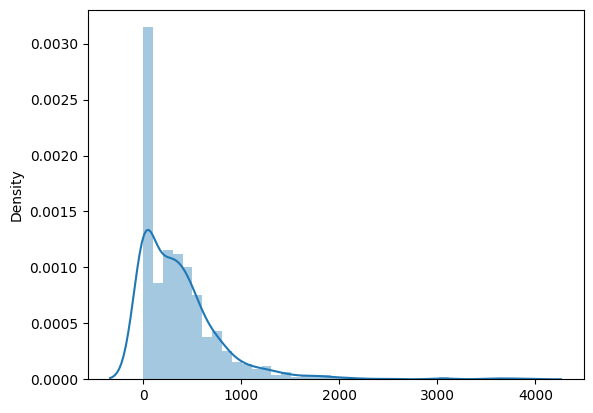

In [ ]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.1242603550295858

In [ ]:
np.average(doc_lengths)

373.9792899408284

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  912 training samples
  102 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 1.6568803787231445.   Elapsed: 0:00:50.
0:  bipartisan" "infidelity" and also has been busy touring the country as a music-based hip-hop act. He can also be seen in the first half of 2013 as a musician touring the country touring the country touring the country performing with other music venues, as well as playing his instruments for music clubs or clubs.

The new album also features collaborations with a band of young kids named Eiko Mor on labels including 'Omega & Fuzzy'.


Trivia: Not one of the original band in 2008 had seen release.

Despite being very active in the club scene, Tenderloin Records have seen a label that made an impressive number of releases. It is known for the success of the project, which made a number of awards, including the prestigious 2005 Grammy for Best Album. It is also known for the work of the young DJ and his friend, Hiko Mor.

With his new album, Tenderloin Records


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 1.174133539199829.   Elapsed: 0:01:43.
0:  increasing
’t the word or name of a institution, such as “techno’tor of arts, production or media’, we’d be sure this “tradition of the Techno’s has been a staple of the Techno’s weekly and monthly events over the years. For those occasions, as well as for festivals, clubs, parties and events, the Techno, like a few other places “Tripwire’ or Techno’s, can be’troubled.

So why? institutions have an important role in’t the “techno’s” and what people are going to see at events like parties and conventions, as well as in parties. In this way, you can find people of every genre who come to Techno.

Since there is no need to be an underground or underground techno club or techno club like “


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 0.006638391874730587.   Elapsed: 0:02:37.
0: day" as an young lady. "My name is Tim."


Just year old and I have been running as a young lady in Chicago. Having spent my summers in various cities including Chicago, I have spent a few years in Chicago traveling and performing music. My roots are deep and I have stayed grounded in Chicago until I entered my second year as an artist. 
 
My first live music gig was in 1991 on the East End, where I set up my own label Tresor. 
After traveling around Chicago for over a year, my new label opened for the Chicago Area label Strobe. 
I was still running my label till 1997, when I finally took a leave of residence, because my relationship with my own labels had become more and more intertwined and I wasn't sure if I would ever play in Chicago. 
My DJ and record label came back to the Chicago House scene with a bang and then followed with a debut EP


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 2.3711891174316406.   Elapsed: 0:03:32.
0:  HangIt’s been years since we have been in the limelight, and the best part’s gone in tandem. With a deep passion for music that comes from all across the planet, and no one at work, our sound has never been without its own sense of identity. From playing DJ’s at clubs like BP’s Berghain, to running the label Unimog, to DJing at parties all over the world, it’s all been around a few years now. Nowadays with the release of The Right Moves EP, and a follow-up to 2015’s acclaimed ‘Aniversary‘, there’s little doubt we've come back from that pivotal moment of becoming part of the global underground music movement’s most respected musical institution.

Nowadays, with a new chapter in the history of ‘Aniversary‘ and a brand new chapter in the way people’s tastes, the

  Average training loss: 2.50
  Training epoch took: 0:04:04

Running Validation...
  Validation Loss: 1.56
  Validation took: 0:00:09

======== Epoch 2 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 0.5751088857650757.   Elapsed: 0:00:53.
0:  foods. house band - DJ-producer & label owner.

This is the label I started on in 2004.
This was where the concept became a reality. 
First it was just for the dancefloor. Then we opened the first parties around.
We were the only label to show up at clubs like Berghain, Panorama Bar and Ibiza (UK), and then we held our own festivals like Sunwaves and Boiler Room. 
It was only then that we felt that we could get ahold of a world class artist, producer and label owner.
The label had an incredible reputation, a lot of good vibes, a plethora of records under our belt to go along with it.
We were given our best records for our favourite artists, but I think many of these artists were just starting out and were just beginning their productions. 
In 2004 they started making some videos for our own productions that had a more mature feel to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 0.8992381691932678.   Elapsed: 0:01:48.
0:  trailA tale of two brothers, a chef and the quintet of techno producers from Hamburg to Amsterdam, Jüri is a rare breed of German-American artist. Jüri started working in the kitchen of his grandfather’s house in Berlin in the early 90’s. This wasn’t long ago; during the early stages of house, the brothers built up a reputation for pushing the boundaries of German house. By combining their love for techno’s soul, experimentation and raw physicality, both brothers now seek to deepen their own musical legacy through a variety of unconventional labels.

As a DJ and producer, Jüri’s production and mixing talents are at an all time peak. At first his work shows a keen understanding for the nuances of electronic music; as well as the dynamics of its musicality, blending these two elements, he seeks to explore new genres and environments that might inform both his musical productions and DJ sets. A musician who transc

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 1.9831353425979614.   Elapsed: 0:02:44.
0: intend

Coordinated by the Berlin chapter of the Institute of Contemporary Art, Dejos is considered as one of Berlin’s most important artists. Besides his performances, his most unique work was created as a poster boy for the legendary 'Rigoberto Corsica' (a label founded at the same time with the pseudonym of Laurent Garnier) in collaboration with a friend of his, Laurent Garnier.

His productions, combined with collaborations with other leading figure figures in contemporary music, such as Depeche Mode, Robert Hood, Depeche Mode Orchestra, Dolly & The Bells, Max Cooper, The xx, Ricardo Villalobos, and Jordasho Plex, have brought Depeche Mode into the limelight. This has been done with a particular emphasis on the music of Jordasho Plex, whose signature sound and distinctive, hypnotic signature has been featured in Depeche Mode’s albums and records.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 1.5244909524917603.   Elapsed: 0:03:39.
0:  surround: The first time that my kids were exposed to the kind of stuff that's been out there. There are loads of things you can play with that's kinda new and fresh.

The first time that my kids were exposed to the kind of stuff that's been out there. There are loads of things you can play with that's kinda new and fresh.

If you've never had any experience with electro, you might want to get a refresher in house music. There are loads of interesting and obscure beats out there, but most of those aren't so exciting to play with other musicians.

The first time that my kids are exposed to the kind of stuff that's been out there. There are loads of things you can play with that's kinda new and fresh.

If you've never had any experience with electro, you might want to get a refresher in house music. There are loads of interesting and obscure beats out there, but most of those aren

  Average training loss: 1.56
 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 1.6418229341506958.   Elapsed: 0:00:53.
0:  reflex


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 1.5825047492980957.   Elapsed: 0:01:45.
0:  displayA young man from the east London suburbs of Oxfordshire has been enlisted by the army in 2008 to oversee the project. 

He quickly became immersed in the scene through clubs and a string of underground releases on labels and websites, but his musical education was very limited. His musical path has seen him play several shows in Wales, Scotland, Northern Ireland, Egypt, Egypt, India, Lebanon, Morocco, South Africa, Tunisia, Egypt, Egypt, and South Africa.

His versatility and creativity has seen him explore other genres, including Electronic and Rock, all while still developing his technical skills.

He’s been a resident DJ since 2006, as well as regularly contributing to several influential BBC shows and festivals, alongside working for the BBC Radio 1 show ‘The One Show’, the BBC Radio 1 Classic FM show ‘Time to Work’, and the DJ competition show ‘Night at A Guy's’.

Since 2006, he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 0.029884953051805496.   Elapsed: 0:02:40.
0:  pastor


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 2.1851282119750977.   Elapsed: 0:03:32.
0:  illicit-festival-techno-music-disco-comedy.

After releasing a strong debut debut EP on Ostgut Ton and a remix EP for Cocoon from 2009, his breakthrough 12" was followed by the singles "It's a Love Story" and "Love is Power".

After releasing 12"s via Cocoon and Cocoon 3, he has released several collaborations with fellow French producers like Danilo Claussell, Dusseldorf, and Nils Nilsson.


In 2011 he became the first ever Brazilian artist to release a solo LP on Ostgut Ton.

His debut single on Cocoon appeared on Ostgut Ton 3 in November, 2014.

Mixed by Dusseldorf in 2015, this was followed by the single ‘Love is Power’ on Cocoon 4 in February 2018.

Mixed via Cocoon ‘love is Power’ in March 2017 and the

  Average training loss: 1.39
  Training epoch took: 0:04:04

Running Validation...
  Validation Loss: 1.54
  Validation took: 0:00:09

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 0.05280693247914314.   Elapsed: 0:00:53.
0:  Liberation


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 2.6863536834716797.   Elapsed: 0:01:45.
0:  NamChilean dj, producer, producer, remixer..One of the most respected dj duo in South America, Santiago de Chile is a key figure in the electronic underground electronic scene.

With his deep connection with Santiago, Chile’s legendary clubs and a taste that goes beyond the typical club culture, Santiago de Chile is in prime position to influence international dance music. From the club culture to the underground scene, Santiago de Chile is one of a handful of global electronic artists that is constantly touring the world.

In addition to his DJ work, Santiago’s main focus of club culture is Techno. He is a member of the influential family of Chico and Huichan producers with many releases and an extensive discography of original productions.
He is a DJ in his own right, a highly-rated club DJ at the very top of the industry, contributing much to the high profile of the global techno scene. He also supports Chil

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 1.489551305770874.   Elapsed: 0:02:40.
0: IONBambounou is one of the most versatile and internationally acclaimed artists from the Tunisian electronic music scene. His solo productions are set on the boundary-pushing boundaries of techno and house and combine a multitude of styles: 4/4 techno, industrial, trance, acid, raw, IDM, ambient, IDM, techno, house and beyond. His signature style has been shown off at festivals like DC10, Panorama Bar Festival, De School, Dekmantel, Movement Detroit, Concrete, Rex Club, Movement Paris and many others.Bambounou is part of the Tunisian Electronic Music generation that is taking a risk and moving forward in a unique, unpredictable and dynamic way. As a former resident of Concrete for 14 years, this is his first release under the name Bambounou since the group closed in 2011. His approach is one of experimentation and discovery, not linear progression. Bambounou is a visionary, and creative force; a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 0.6300668120384216.   Elapsed: 0:03:36.
0:  glimpse

  Average training loss: 1.23
  Training epoch took: 0:04:05

Running Validation...
  Validation Loss: 1.57
  Validation took: 0:00:09

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 1.0885357856750488.   Elapsed: 0:00:52.
0:  LaureI've been DJ’ing since 1999. A producer, songwriter, and DJ.There are few DJs who can claim to have been DJ’ed for more than a decade. That’s not even scratching the surface. DJ’ing is the fastest-growing profession worldwide and has been growing at an rapid pace for a number of years. It’s been in-demand programming since 1999 and, over the years, has been growing at breathtaking rate. DJ’ing is at the forefront of many aspects of the global music culture. It’s a profession that has been around for quite a while, thanks in part to the highly respected, hugely successful, and highly respected DJ and DJ magazine The Face. 

It’s hard being a DJ, whether you’re an established partygoer, a travelling artist, or, rather, in a club. The rules and the customs of the game are very different from those


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 2.734250545501709.   Elapsed: 0:01:47.
0: ism


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 0.047105059027671814.   Elapsed: 0:02:39.
0: ounCroydon & London-based DJ.Evolver.Hexam Aydin’s record label is the home of many contemporary dance music talents. Exclaiming her position within the underground scene, she has quickly found herself relocating to London’s flourishing and highly-regarded HEXA.

Exclaiming her position within the underground scene, she has quickly found herself relocating to London’s flourishing and highly-regarded HEXA.

A key milestone was a meeting with Exclaiming herself on 26 January 2017, giving her the opportunity to release an official remix of DJ Tennis’s ‘Love Rehab’ that will surely have her charting success. This remix provided the perfect platform to launch Exclaiming’ brand of forward thinking techno, whilst demonstrating a truly original and forward thinking approach to the development of underground techno.

This remix has received rave reviews as well as a slew of well received


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 1.069090723991394.   Elapsed: 0:03:34.
0:  electionFriedrich von Oswald is the undisputed kingpin of Bavaria's electronic underground techno movement and one of the most prolific producers and DJs to grace the scene. He holds a residency at the legendary Berghain Berghain where he draws highly on an extensive discography of seminal artists from Blakenschitsch, Kraftwerk, DFA, Depeche Mode and of course, Krautrock and his own productions.

Born in 1971 in Frankfurt, fuses his varied tastes with a passion for a wide range of experimental music including rockabilly, electro-pop, experimental techno, jazz, breaks and soulful disco. From 1970 Frankfurt, fuses the interests of Bachmann with the sounds of the 1970s as well as the new millennium in techno, and he produces in a unique musical style that not only reflects the zeitgeist but also the creative spirit of today. Friedrich has spent the last two decades building his label Berghain, releasing music

  Av

Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.501521,1.558063,0:04:04,0:00:09
2,1.562925,1.534791,0:04:11,0:00:09
3,1.388618,1.543444,0:04:04,0:00:09
4,1.233530,1.570385,0:04:05,0:00:09
5,1.105017,1.615391,0:04:05,0:00:09


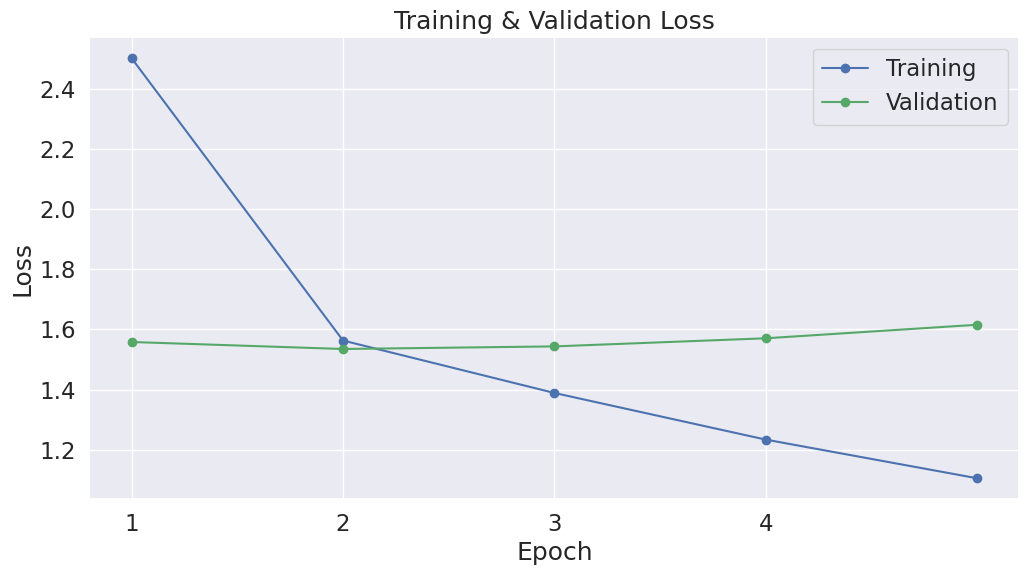

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


In [ ]:
!ls -l --block-size=K ./model_save/

total 487540K
-rw------- 1 root root      1K Jun 11 07:09 added_tokens.json
-rw------- 1 root root      1K Jun 11 07:09 config.json
-rw------- 1 root root      1K Jun 11 07:09 generation_config.json
-rw------- 1 root root    446K Jun 11 07:09 merges.txt
-rw------- 1 root root 486114K Jun 11 07:09 model.safetensors
-rw------- 1 root root      1K Jun 11 07:09 special_tokens_map.json
-rw------- 1 root root      1K Jun 11 07:09 tokenizer_config.json
-rw------- 1 root root    976K Jun 11 07:09 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

ls: cannot access './model_save/pytorch_model.bin': No such file or directory


In [ ]:
# Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


NameError: name 'device' is not defined

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|> Mike was a singer"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

NameError: name 'device' is not defined

These aren't bad at all!
